In [1]:
import numpy as np
from scipy import *
from scipy import sparse
from scipy.sparse.linalg import spsolve
from matplotlib.pyplot import *
import h5py
from Data_Core.experiment import *
from Data_Core.digital_twin import *
from Data_Core.fft_analysis import *
from tqdm import tqdm

In [1]:
35/1.5

23.333333333333332

# Import Data

In [2]:
def read_data_map(file):

    hf = h5py.File(file, 'r')
    sample = file.split("\\")[-1]
    keys = [key for key in hf.keys()]
    sample = keys[0].split(' ')[-1]

    spectrums = np.array([np.ndarray.flatten(np.array(list(hf['Sample_ID: ' + sample]['Spot_' + str(i)]['Shot_0']['raw_spectrum']))) for i in range(0,
                                                        len(list(hf['Sample_ID: ' + sample])))])
    positions = np.array([np.ndarray.flatten(np.array(list(hf['Sample_ID: ' + sample]['Spot_' + str(i)]['position']))) for i in range(0,
                                                        len(list(hf['Sample_ID: ' + sample])))])
    wavelengths = np.array(hf['System properties']['wavelengths'])
        
    unique_x = np.unique(positions[:,0])
    unique_y = np.unique(positions[:,1])
    
    nx = len(unique_x)
    ny = len(unique_y)
    indexes = np.lexsort((positions[:, 0],positions[:, 1]))
    spectrums = spectrums[indexes, :]
    spectrums = np.array(spectrums.reshape((ny, nx, -1)))
    # print(spectrums.shape)
    positions = np.array(positions[indexes])
    
    hf.close()
    return spectrums, wavelengths, positions, unique_x, unique_y

In [6]:
def baseline_als_optimized(y, lam, p, niter = 10):
    L = len(y)
    D = sparse.diags([1, -2, 1],[0, -1, -2], shape = (L, L - 2))
    D = lam * D.dot(D.transpose()) # Precompute this term since it does not depend on `w`
    w = np.ones(L)
    W = sparse.spdiags(w, 0, L, L)
    for i in range(niter):
        W.setdiag(w) # Do not create a new matrix, just update diagonal values
        Z = W + D
        z = spsolve(Z, w*y)
        w = p * (y > z) + (1 - p) * (y < z)
    return y - z

%matplotlib widget
ix, iy = 10, 10
##optimize parameters
lam = 1e2
# lam = 100000
p = 1e-4
# p = 0.05

In [4]:
file = r'D:/Data/Data_LIBS/Vidros/mix1.h5'
spectrums, wavelengths, positions, unique_x, unique_y = read_data_map(file)

In [8]:
from multiprocessing import Pool
spectrums = spectrums.reshape(spectrums.shape[0]*spectrums.shape[1], -1)

pool = Pool(8)

with pool as p:
    pro_data = p.map(baseline_als_optimized, spectrums)

: 

In [5]:
pro_data = np.array(spectrums)

for i in tqdm(range(0, pro_data.shape[0])):
    for j in range(0, pro_data.shape[1]):
        spec = 1 * pro_data[i, j, :]
        pro_data[i, j, :] = spec - baseline_als_optimized(spec, lam = lam, p = p, niter = 10)

100%|██████████| 42/42 [05:10<00:00,  7.40s/it]


In [10]:
wavelengths = wavelengths.flatten()

In [11]:
mean_signal = np.mean(spectrums, axis = (0, 1))
min_signal = np.min(spectrums, axis = (0, 1))
max_signal = np.max(spectrums, axis = (0, 1))

# Interface

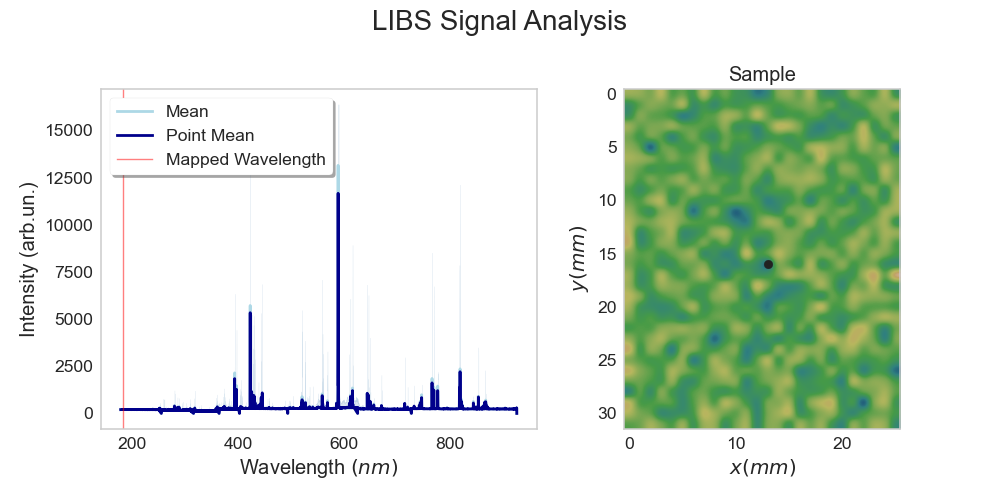

In [58]:
%matplotlib widget
from matplotlib import gridspec

# fig, ax = subplots(1, 3, figsize = [10, 7], gridspec_kw = {'width_ratios': [1.1, 0.6, 0.6]})
fig = figure(tight_layout = True, figsize = (10, 5))
gs = gridspec.GridSpec(1, 2)

ax1 = fig.add_subplot(gs[0])
ax2 = fig.add_subplot(gs[1])

x_center, y_center = spectrums.shape[1]//2, spectrums.shape[0]//2
radius = 3

fig.suptitle('LIBS Signal Analysis', fontsize = 20)

axs = ax1
axs.plot(wavelengths, mean_signal, lw = 2, ls = '-', color = 'lightblue', label = 'Mean')
meanr, = axs.plot(wavelengths, spectrums[x_center - radius:x_center + radius, y_center - radius:y_center + radius].mean(axis = (0, 1)),
                  color = 'darkblue',
                  label = 'Point Mean',
                  lw = 2)
axs.fill_between(wavelengths, min_signal, max_signal, color = 'steelblue', alpha = 0.2)

wn = 120
line = axs.axvline(wavelengths[wn], lw = '1', alpha = 0.5, color = 'red', label = 'Mapped Wavelength')
axs.set_xlabel(r'Wavelength $(nm)$')
axs.set_ylabel(r'Intensity (arb.un.)')
axs.legend(fancybox = True, shadow = True)
axs.grid(False)

axs = ax2
axs.set_title('Sample')
# axs.imshow(image_var, extent = (0, 90, 0, 80))
# axs.imshow(spectrum[:, :, wn], cmap = my_cmap, extent = (0, 90, 0, 80), interpolation = 'gaussian')
axs.imshow(spectrums[:, :, wn], cmap = 'gist_earth', interpolation = 'gaussian')
sca = axs.scatter(x_center, y_center, color = 'k', s = 40)
axs.set_xlabel(r'$x(mm)$')
axs.set_ylabel(r'$y(mm)$')
axs.grid(False)

def update_map(wn):
    # ax2.imshow(image_var, extent = (0, 90, 0, 80))
    # im1 = ax2.imshow(spectrum[:, :, wn], cmap = my_cmap, extent = (0, 90, 0, 80), interpolation = 'gaussian') 
    im1 = ax2.imshow(spectrums[:, :, wn], cmap = 'gist_earth', interpolation = 'gaussian') 
    line.set_xdata(wavelengths[wn])

def onclick(event):
    if event.dblclick:
        if event.inaxes == ax1:
            ix, iy = event.xdata, event.ydata
            wn = find_wavelength_index(ix, wavelengths)
            update_map(wn)
            fig.canvas.draw_idle()
        elif event.inaxes == ax2:
            xx, yy = int(event.xdata), int(event.ydata)
            sca.set_offsets([xx, yy])
            try:
                meanr.set_data(wavelengths, spectrums[xx - radius:xx + radius, yy - radius:yy + radius].mean(axis = (0, 1)))
            except:
                meanr.set_data(wavelengths, spectrums[xx, yy])
            fig.canvas.draw_idle()
        
cid = fig.canvas.mpl_connect('button_press_event', onclick)


fig.tight_layout()